## Lesson 05
### Random Forest

In [1]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

#### Sample Data

In [2]:
# Generate data (100 objects, 2 features)

classification_data, classification_labels = datasets.make_classification(n_samples = 100,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant = 0, 
                                                      n_clusters_per_class = 1, random_state = 42)

In [30]:
classification_data.shape

(100, 2)

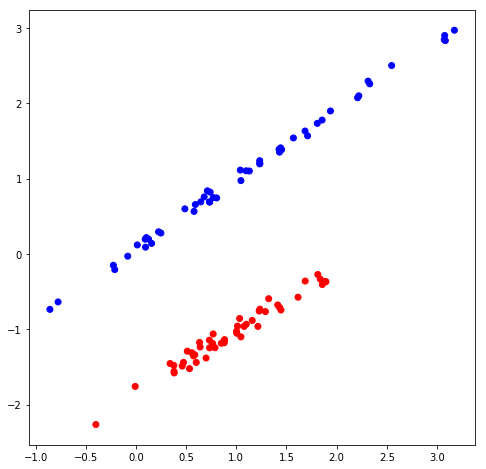

In [3]:
# Visualize generated data

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

#### Bootstrap

In [4]:
# Generate N bootstrap selections and subsets of features for finding split in node

random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [5]:
def get_subsample_classification(len_sample):
    # save the indexes of features
    sample_indexes = [i for i in range(len_sample)]
    
    # recommended subsample length: sqrt(len_sample) for classification, len_sample/3 for regression
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [6]:
def get_subsample_regression(len_sample):
    # save the indexes of features
    sample_indexes = [i for i in range(len_sample)]
    
    # recommended subsample length: sqrt(len_sample) for classification, len_sample/3 for regression
    len_subsample = int(len_sample / 3)
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

#### Decision Tree

In [7]:
# Tree Node

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # index of the feature by which the value is compared with the threshold (t) in the node
        self.t = t  # threshold value
        self.true_branch = true_branch  # subtree where the node condition is satisfied (e.g. "left") 
        self.false_branch = false_branch  # subtree where the node condition is not satisfied (e.g. "right")

In [8]:
# Tree Leaf (Terminal Node)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # count the number of objects in each class
        classes = {}  # dictionary "class: number_of_objects"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        # prediction of the leaf is the class having the maximum number of objects    
        prediction = max(classes, key=classes.get)
        return prediction  

#### Gini criterion

In [9]:
# Gini criterion

def gini(labels):
    #  count the number of objects in each class
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  calculate the criterion
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

#### Model quality

In [10]:
# Model quality estimation

def quality(left_labels, right_labels, current_gini):

    # portion of left subtree selection
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

#### Build Tree

In [11]:
# Split dataset into "left" and "right" in a node

def split(data, labels, index, t):
    
    # split dataset by the threshold value
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [12]:
# Find best split

def find_best_split(data, labels):
    
    # tree constraints
    min_leaf = 1  # minimum number of objects in a leaf node, recommended values: 1 for classification, 5 for regression

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    # select index from subselection (for classification, the length is sqrt(n_features))
    subsample = get_subsample_classification(n_features)
    
    for index in subsample:
        # check only unique feature values, excluding repeated values
        t_values = np.unique([row[index] for row in data])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            
            # skip splits where the tree constraints are met:
            # the node contains fewer objects than specified in min_leaf
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
                       
            current_quality = quality(true_labels, false_labels, current_gini)
            
            # pick the threshold with the maximum quality increase 
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [13]:
# Build tree recursively

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    # base case: stop recursion when there is no quality increase
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # build two subtrees recursively
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # return the node class with its two subtrees
    return Node(index, t, true_branch, false_branch)

#### Random Forest

In [14]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

#### Class Prediction

In [15]:
def classify_object(obj, node):

    # base case: stop recursion when the node is a leaf
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [16]:
# prediction function for a single tree

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [17]:
# prediction by voting trees

def tree_vote(forest, data):

    # add predictions from all trees to a list
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # create a list of predictions for each object
    predictions_per_object = list(zip(*predictions))
    
    # for each object, prediction with most voted trees wins
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

#### Apply Model

In [18]:
# Split selection into train and test

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, classification_labels, 
                                                                                    test_size = 0.3, random_state = 1)

In [19]:
# Accuracy metric is the proportion of correct answers
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

#### Random Forest with Different Number of Trees

In [20]:
def random_forest_n_trees(n_trees):
    
    my_forest = random_forest(train_data, train_labels, n_trees)
    
    # Get vote-based prediction for train data
    train_answers = tree_vote(my_forest, train_data)
    
    # Get vote-based prediction for test data 
    test_answers = tree_vote(my_forest, test_data)
    
    # Calculate accuracy on train data
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Accuracy of random forest with {n_trees} trees on train data: {train_accuracy:.3f}')
    
    # Calculate accuracy on test data
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Accuracy of random forest with {n_trees} trees on test data: {test_accuracy:.3f}')

In [21]:
random_forest_n_trees(1)

Accuracy of random forest with 1 trees on train data: 97.143
Accuracy of random forest with 1 trees on test data: 96.667


In [22]:
random_forest_n_trees(3)

Accuracy of random forest with 3 trees on train data: 100.000
Accuracy of random forest with 3 trees on test data: 100.000


In [23]:
random_forest_n_trees(10)

Accuracy of random forest with 10 trees on train data: 98.571
Accuracy of random forest with 10 trees on test data: 100.000


In [24]:
random_forest_n_trees(50)

Accuracy of random forest with 50 trees on train data: 100.000
Accuracy of random forest with 50 trees on test data: 96.667


In [25]:
n_trees = 50
my_forest = random_forest(train_data, train_labels, n_trees)
train_answers = tree_vote(my_forest, train_data)
test_answers = tree_vote(my_forest, test_data)
train_accuracy = accuracy_metric(train_labels, train_answers)    
test_accuracy = accuracy_metric(test_labels, test_answers)

Text(0.5, 1.0, 'Test accuracy=100.00')

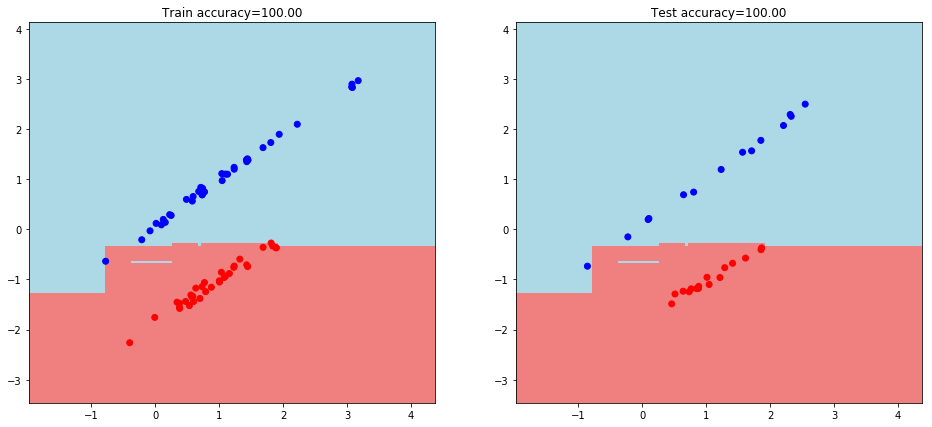

In [27]:
# Visualize the forest

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# plot for train data
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# plot for test data
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')